In [1]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Random

In [2]:
include("lazy_struct.jl")
include("low_discrepancy.jl")
include("optim.jl")
include("rbf_surrogate.jl")
include("testfns.jl")
include("rollout2.jl")
include("utils.jl")

inbounds (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Needs Support
We currently sample from a multi-output GP using a combination of the mean and predictive mean of $\mathscr{F}$ and not using $\mathscr{G}$. We should be sampling from a multi-output GP, i.e. we need to write support for doing so. We use $\mathscr{F}$ to determine our sample location, but we sample from $\mathscr{G}$ for gradient and function values.
$$
\nabla_{x^k}\bar{\alpha}(x^k|\mathscr{F}_{k-1})=\textbf{0} \\ \left(\hat{f}_k, \nabla\hat{f}_k\right) \sim \mathscr{G}_{k-1}(x^k)
$$

<span style="color: red;">Thoughts</span>: The trajectory struct needs to maintain the multi-output GP for each trajectory. We need the gradient information to compute perturbations, which are distinct from the multi-output GP being maintained.

(Needs Care) Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.
(Think Carefully) How do we handle computing covariance kernel matrix of observations where we have partial gradient observations.

In [3]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 5
MC_SAMPLES = 1000
HORIZON = 1
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [4]:
# Setup toy problem
testfn = TestGramacyLee()
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
# random_number_stream = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
random_number_stream = rand(MC_SAMPLES, testfn.dim+1, HORIZON+1);

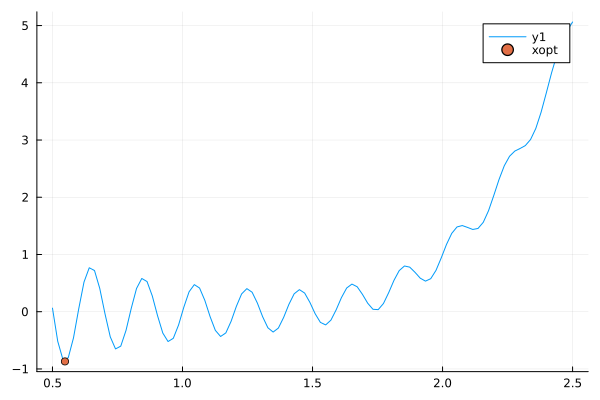

In [5]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [6]:
# Gather initial samples/experimental data
N, θ = 1, [1.]
X = reshape([.9], 1, 1)
ψ = kernel_matern52(θ);

### 3. Construct the ground truth surrogate model

In [7]:
sur = fit_surrogate(ψ, X, testfn.f)
θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

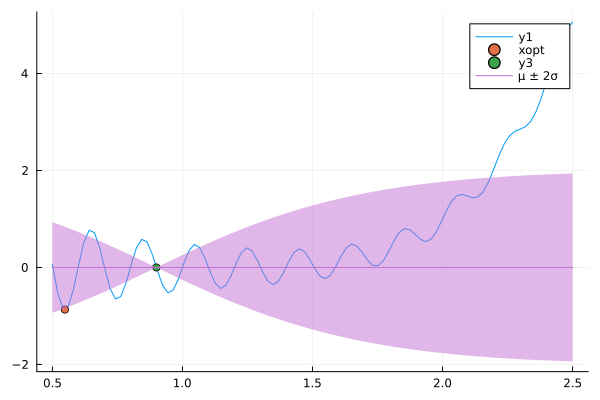

In [8]:
domain = lbs[1]:.01:ubs[1]
scatter!(sur.X, sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")

### 4. Setup hyperparameters for stochastic gradient descent

In [9]:
λ = 1e-1; # Vanilla stochastic gradient descent

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

In [12]:
T, HEIbest = nothing, nothing
surs = []
all_mb_results = []
minibatch = nothing

for budget_iteration in 1:BUDGET
    # minibatch = randsample(BATCH_SIZE, testfn.dim, lbs, ubs)
    minibatch = lbs[1]:.01:ubs[1]
    mb_results = Dict{Vector{Float64}, Any}()
    
    ndx = 1
    for x0 in eachcol(minibatch)
        # Initialize α and ∇α
        α, ∇α = 0., zeros(length(x0))
        αs, ∇αs = [], []
        
        # Grab each input location and convert to a column vector
        x0 = x0[:]
        
        # Setup params for SGD convergence criteria
        epoch = 1
        
        # Perform SGD iterations
        while sgd_hasnot_converged(epoch, ∇αs, MAX_SGD_ITERS) && inbounds(x0, lbs, ubs)
            # Monte-carlo integrate trajectory for x0
            for sample in 1:MC_SAMPLES
                # Make a copy of our surrogate to pass to the trajectory struct
                # for fantasized computations
                fsur = Base.deepcopy(sur)
                fantasy_ndx = size(fsur.X, 2) + 1

                # Rollout trajectory
                T = Trajectory(fsur, x0, HORIZON, fantasy_ndx)
                HEIbest = rollout3!(T, lbs, ubs; RNstream=random_number_stream[sample,:,:])

                # Evaluate rolled out trajectory
                α += α3(T)
                ∇α += ∇α3(T, HEIbest)
                # break
            end # endfor sample

            # Average trajectories
            α /= MC_SAMPLES
            ∇α /= MC_SAMPLES
            
            # Update history
            push!(αs, α)
            push!(∇αs, first(∇α))

            # Update x0 using Stochastic Gradient Descent
            x0 = vec(x0 - λ*∇α)
            if mod(epoch, 10) == 0
                println("$ndx.) α($x0): $α -- ∇α($x0): $∇α")
                println("Epoch #$epoch | x0: $x0")
            end
            epoch += 1
        end
        ndx += 1
        
        # Add results for current x0
        setindex!(mb_results, (α, ∇α), x0)
    end # endfor x0
    
    push!(all_mb_results, mb_results)
    xnew = get_maximum_key(mb_results)
    X = hcat(sur.X, xnew)
    println("Proposed Sample Location: $xnew")

    sur = fit_surrogate(ψ, X, testfn.f)
    θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);
end # endfor budget_iteration

Proposed Sample Location: 0.0


LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [13]:
T, HEIbest = nothing, nothing
surs = []
all_mb_results = []
minibatch = nothing
dense_αs = []
dense_∇αs = []
dense_all_αs = []
ndx = 1

for budget_iteration in 1:BUDGET
    # minibatch = randsample(BATCH_SIZE, testfn.dim, lbs, ubs)
    minibatch = collect(lbs[1]:.01:ubs[1])'[:,:]
    
    for x0 in eachcol(minibatch)
        try
            push!(dense_all_αs, [])
            # Initialize α and ∇α
            α, ∇α = 0., zeros(length(x0))
            αs, ∇αs = [], []

            # Grab each input location and convert to a column vector
            x0 = x0[:]
            println(typeof(x0), "--", x0)

            # Setup params for SGD convergence criteria
            epoch = 1

            # Monte-carlo integrate trajectory for x0
            for sample in 1:MC_SAMPLES
                # Make a copy of our surrogate to pass to the trajectory struct
                # for fantasized computations
                fsur = Base.deepcopy(sur)
                fantasy_ndx = size(fsur.X, 2) + 1

                # Rollout trajectory
                T = Trajectory(fsur, x0, HORIZON, fantasy_ndx)
                HEIbest = rollout3!(T, lbs, ubs; RNstream=random_number_stream[sample,:,:])

                # Evaluate rolled out trajectory
                cur_α = α3(T) + sur(x).EI
                cur_∇α = ∇α3(T, HEIbest)
                α += cur_α
                ∇α += cur_∇α
                push!(dense_all_αs[end], cur_α)
            end # endfor sample

            # Average trajectories
            α /= MC_SAMPLES
            ∇α /= MC_SAMPLES

            # Update history
            push!(αs, α)
            push!(∇αs, first(∇α))
            push!(dense_αs, α)
            push!(dense_∇αs, first(∇α))
        catch e
        end
    end # endfor x0
end # endfor budget_iteration

Vector{Float64}--[0.5]
Vector{Float64}--[0.51]
Vector{Float64}--[0.52]
Vector{Float64}--[0.53]
Vector{Float64}--[0.54]
Vector{Float64}--[0.55]
Vector{Float64}--[0.56]
Vector{Float64}--[0.57]
Vector{Float64}--[0.58]
Vector{Float64}--[0.59]
Vector{Float64}--[0.6]
Vector{Float64}--[0.61]
Vector{Float64}--[0.62]
Vector{Float64}--[0.63]
Vector{Float64}--[0.64]
Vector{Float64}--[0.65]
Vector{Float64}--[0.66]
Vector{Float64}--[0.67]
Vector{Float64}--[0.68]
Vector{Float64}--[0.69]
Vector{Float64}--[0.7]
Vector{Float64}--[0.71]
Vector{Float64}--[0.72]
Vector{Float64}--[0.73]
Vector{Float64}--[0.74]
Vector{Float64}--[0.75]
Vector{Float64}--[0.76]
Vector{Float64}--[0.77]
Vector{Float64}--[0.78]
Vector{Float64}--[0.79]
Vector{Float64}--[0.8]
Vector{Float64}--[0.81]
Vector{Float64}--[0.82]
Vector{Float64}--[0.83]
Vector{Float64}--[0.84]
Vector{Float64}--[0.85]
Vector{Float64}--[0.86]
Vector{Float64}--[0.87]
Vector{Float64}--[0.88]
Vector{Float64}--[0.89]
Vector{Float64}--[0.9]
Vector{Float64}--[0.9